# Build Figures for SHINE 2017 Poster
Some figures for my poster at SHINE 2017. Use reduced data from my Loops Workshop talk.

In [148]:
import os
import sys
import io
import copy
import glob
import urllib
from collections import OrderedDict

import roman
import numpy as np
import pandas
from scipy.optimize import curve_fit
from scipy.interpolate import interp1d,splev,splrep
from scipy.ndimage import map_coordinates,gaussian_filter
import matplotlib.pyplot as plt
import matplotlib.colors
from matplotlib.ticker import MaxNLocator
import seaborn.apionly as sns
import astropy.units as u
import astropy.constants as const
from astropy.io import ascii
from astropy.table import Table
from sunpy.map import Map,GenericMap
from ChiantiPy.tools import filters as ch_filters
import ChiantiPy.tools.util as ch_util
import hissw

import synthesizAR
from synthesizAR.instruments import InstrumentSDOAIA,InstrumentHinodeEIS
from synthesizAR.util import EISCube,EMCube
from synthesizAR.atomic import EmissionModel
from synthesizAR.model_ext import power_law_transform

sns.set_palette('deep')

%matplotlib inline

In [2]:
frequencies = [250,750,2500,5000]

## Forward Modeling

Plot the magnetogram with the fieldlines overplotted.

In [3]:
base_field = synthesizAR.Skeleton.restore('/data/datadrive1/ar_forward_modeling/systematic_ar_study/base_noaa1109/')

No HMI fits file supplied. A new HMI map object will not be created.
yt : [INFO     ] 2017-07-20 17:10:56,159 Parameters: current_time              = 0.0
yt : [INFO     ] 2017-07-20 17:10:56,160 Parameters: domain_dimensions         = [96 96 96]
yt : [INFO     ] 2017-07-20 17:10:56,161 Parameters: domain_left_edge          = [  8.88147851e+09   1.66017386e+09   7.23009049e+08]
yt : [INFO     ] 2017-07-20 17:10:56,162 Parameters: domain_right_edge         = [  4.35656994e+10   3.67056887e+10   3.54274434e+10]
yt : [INFO     ] 2017-07-20 17:10:56,163 Parameters: cosmological_simulation   = 0.0


In [4]:
width = base_field.hmi_map.dimensions.x*base_field.hmi_map.scale.x
height = base_field.hmi_map.dimensions.y*base_field.hmi_map.scale.y
left = base_field.hmi_map.center.x - width/2.
right = left + width
bottom = base_field.hmi_map.center.y - height/2.
top = bottom + height

Load in the HMI observation again because we want it at full resolution.

In [5]:
hmi_map = Map('/home/wtb2/sunpy/data/hmi_m_45s_2010_09_29_23_51_45_tai_magnetogram.fits')
hmi_map = hmi_map.rotate()
hmi_map = hmi_map.submap(u.Quantity((left,right)),u.Quantity((bottom,top)))

/home/wtb2/anaconda3/envs/systematic-ar-study/lib/python3.5/site-packages/sunpy/image/transform.py:130: RuntimeWarning: Setting NaNs to 0 for higher-order scikit-image rotation
  RuntimeWarning)


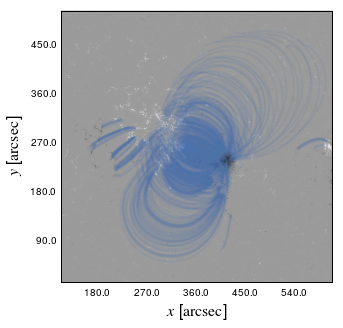

In [19]:
fig = plt.figure(figsize=(8,5))
ax = fig.add_subplot(111,projection=hmi_map)
hmi_map.plot(annotate=True,axes=ax,title=False)
#ax.set_title(r'HMI Observation NOAA 1109')
# axes and tick label sizing
ax.coords[0].set_ticklabel(size=plt.rcParams['xtick.labelsize'])
ax.coords[1].set_ticklabel(size=plt.rcParams['ytick.labelsize'])
ax.coords[0].set_axislabel(r'$x$ [$\mathrm{{{}}}$]'.format(u.Unit(hmi_map.meta['cunit1'])),
                           size=plt.rcParams['axes.labelsize'])
ax.coords[1].set_axislabel(r'$y$ [$\mathrm{{{}}}$]'.format(u.Unit(hmi_map.meta['cunit2'])),
                           size=plt.rcParams['axes.labelsize'])
# grids and tick sizing
ax.coords[0].grid(alpha=0)
ax.coords[1].grid(alpha=0)
for stream, _ in base_field.streamlines:
        ax.plot(base_field._convert_angle_to_length(stream[:, 0]*u.cm,working_units=u.arcsec).to(u.deg),
                 base_field._convert_angle_to_length(stream[:, 1]*u.cm,working_units=u.arcsec).to(u.deg),
                 alpha=0.1, color=sns.color_palette()[0], transform=ax.get_transform('world'))
fig.savefig('../figures/hmi_map_with_lines.pdf')

Some hydrodynamic plots

In [9]:
low_freq_field = synthesizAR.Skeleton.restore('/data/datadrive1/ar_forward_modeling/systematic_ar_study/noaa1109_tn2500/field_checkpoint/')

No HMI fits file supplied. A new HMI map object will not be created.
yt : [INFO     ] 2017-07-20 17:15:12,047 Parameters: current_time              = 0.0
yt : [INFO     ] 2017-07-20 17:15:12,048 Parameters: domain_dimensions         = [96 96 96]
yt : [INFO     ] 2017-07-20 17:15:12,049 Parameters: domain_left_edge          = [  8.88147851e+09   1.66017386e+09   7.23009049e+08]
yt : [INFO     ] 2017-07-20 17:15:12,050 Parameters: domain_right_edge         = [  4.35656994e+10   3.67056887e+10   3.54274434e+10]
yt : [INFO     ] 2017-07-20 17:15:12,051 Parameters: cosmological_simulation   = 0.0


In [11]:
low_freq_field.loops[0].electron_temperature.shape

(1002, 20)

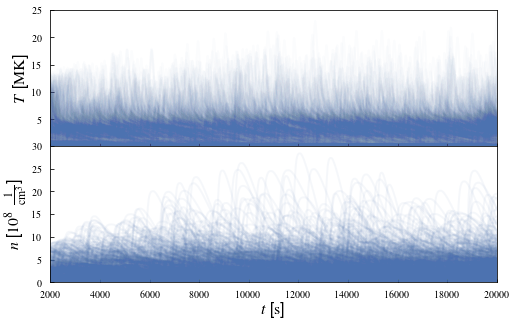

In [23]:
fig,axes = plt.subplots(2,1,figsize=(8,5),sharex=True)
plt.subplots_adjust(hspace=0)
for loop in low_freq_field.loops:
    axes[0].plot(loop.time,loop.electron_temperature[:,0].to(u.MK),color=sns.color_palette()[0],alpha=0.02,lw=2)
    axes[1].plot(loop.time,loop.density[:,0]/1e9,color=sns.color_palette()[0],alpha=0.05,lw=2)
axes[0].set_xlim([2e3,2e4])
axes[0].set_ylim([0.1,25])
axes[1].set_ylim([0.1,30])
axes[1].set_xlabel(r'$t$ [{:latex}]'.format(loop.time.unit))
axes[0].set_ylabel(r'$T$ [{:latex}]'.format(u.MK))
axes[1].set_ylabel(r'$n$ [$10^8$ {:latex}]'.format((u.cm**(-3))))
axes[0].tick_params(axis='both',direction='in')
axes[1].tick_params(axis='both',direction='in')
fig.savefig('../figures/hydrodynamics.pdf')

## Heating Model

In [ ]:
event_energies = {'{}'.format(freq):[] for freq in frequencies}
event_wait_times = {'{}'.format(freq):[] for freq in frequencies}

In [ ]:
for freq in frequencies:
    if type(freq) == int:
        field = synthesizAR.Skeleton.restore('/data/datadrive1/ar_forward_modeling/systematic_ar_study/noaa1109_tn{}/field_checkpoint/'.format(freq))
    else:
        field = synthesizAR.Skeleton.restore('/data/datadrive2/ar_viz/systematic_ar_study/noaa1109_tn750-ion/field_checkpoint/')
    for loop in field.loops:
        num_events = len(loop.hydro_configuration['heating']['events'])
        tmp_event_energies = []
        for i,event in enumerate(loop.hydro_configuration['heating']['events']):
            if i > 0:
                event_wait_times['{}'.format(freq)].append(event['event']['rise_start'] 
                                        - loop.hydro_configuration['heating']['events'][i-1]['event']['rise_end'])
            tmp_event_energies.append(event['event']['magnitude'])
            event_energies['{}'.format(freq)].append(event['event']['magnitude'])

In [ ]:
fig = plt.figure(figsize=(8,6))
ax = fig.gca()
for freq in [250,750,2500,5000]:
    ax.hist(event_wait_times['{}'.format(freq)],
            log=True,bins='fd',histtype='step',lw=2,
            label=r'$\langle t_N\rangle={}$ s'.format(freq))
ax.set_xscale('log')
ax.set_ylim([1,5e3])
ax.set_xlim([9e1,2e4])
ax.set_xlabel(r'$t_N$ [{:latex}]'.format(u.s))
ax.set_ylabel(r'Number of Events')
leg = ax.legend(loc=1,frameon=False)
fig.savefig('../figures/wait_time_distributions.pdf',dpi=1000)

## Spectroscopic Details
Instantiate emission model

In [140]:
emission_model = EmissionModel.restore('/data/datadrive1/ar_forward_modeling/systematic_ar_study/emission_model1109_full/')

H I psplups file not found
He II psplups file not found
N VII psplups file not found
O VIII psplups file not found
Ne X psplups file not found
Na XI psplups file not found
Mg XII psplups file not found
Al XIII psplups file not found
Si XIV psplups file not found
P XV psplups file not found
S XVI psplups file not found
Cl XVII psplups file not found
Ar XVIII psplups file not found
K XIX psplups file not found
Ca XX psplups file not found
Fe XXVI psplups file not found
Ni XXVIII psplups file not found
He I psplups file not found
C V psplups file not found
N VI psplups file not found
O VII psplups file not found
Ne IX psplups file not found
Na X psplups file not found
Mg XI psplups file not found
Al XII psplups file not found
Si XIII psplups file not found
P XIV psplups file not found
S XV psplups file not found
Cl XVI psplups file not found
Ar XVII psplups file not found
K XVIII psplups file not found
Ca XIX psplups file not found
Fe XXV psplups file not found
Ni XXVII psplups file not f

In [142]:
resolved_wavelengths = np.sort(u.Quantity([rw for ion in emission_model.ions for rw in ion.resolved_wavelengths]))

In [143]:
pressure_const = 1e15*u.K*u.cm**(-3)
class FakeLoop(object):
    electron_temperature = np.logspace(5.1,7.1,100)*u.K
    density = pressure_const/electron_temperature
    
fake_loop = FakeLoop()
i_temperature,i_density = emission_model.interpolate_to_mesh_indices(fake_loop)

In [144]:
contribution_functions = {}
line_names = {}
for ion in emission_model.ions:
    for rw in ion.resolved_wavelengths:
        i_rw = np.where(ion.wavelength==rw)[0][0]
        emiss = map_coordinates(ion.emissivity[:,:,i_rw].value,
                                np.vstack([i_temperature,i_density]),order=3)*ion.emissivity.unit
        ioneq = splev(fake_loop.electron_temperature.value,
                      splrep(emission_model.temperature_mesh[:,0].value,
                             ion.fractional_ionization[:,0].value,k=1),ext=1)
        line_names[rw] = '{} {}'.format(ion.chianti_ion.meta['name'],rw.value)
        contribution_functions[rw] = (1./(np.pi*4.*u.steradian)*0.83
                                           *ioneq*ion.chianti_ion.abundance*emiss/fake_loop.density
                                           *(const.h.cgs*const.c.cgs)/rw.to(u.cm)/u.photon)

In [145]:
resolved_els = list(set([li[1].split(' ')[0].split('_')[0] for li in line_names.items()]))
resolved_els.reverse()

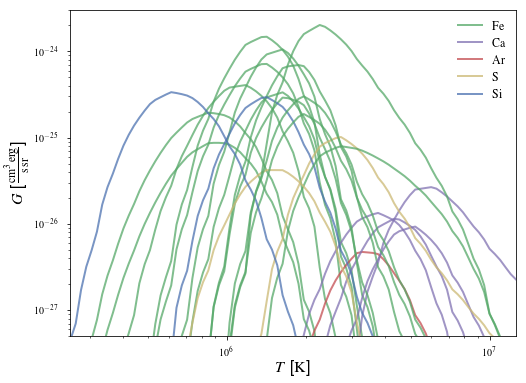

In [146]:
el_colors = {el:sns.color_palette()[i] for i,el in enumerate(resolved_els)}
fig = plt.figure(figsize=(8,6))
ax = fig.gca()
for i,rw in enumerate(resolved_wavelengths):
    el = line_names[rw].split('_')[0]
    spec = ch_util.zion2spectroscopic(ch_util.el2z(el),int(line_names[rw].split('_')[1].split(' ')[0]))
    ax.plot(fake_loop.electron_temperature,contribution_functions[rw],alpha=0.75,
            color=el_colors[el],
            #label='{} {:.2f} $\mathrm{{\mathring{{A}}}}$'.format(spec,float(line_names[rw].split(' ')[1]))
            label='$\mathrm{{{}}}$'.format(spec.split(' ')[0])
           )

ax.set_xscale('log')
ax.set_yscale('log')
ax.set_ylim([5e-28,3e-24])
ax.set_xlim([10.**(5.4),10.**(7.1)])
ax.set_xlabel(r'$T$ [{:latex}]'.format(fake_loop.electron_temperature.unit))
ax.set_ylabel(r'$G$ [{:latex}]'.format(contribution_functions[rw][1].unit))
hand,lab = ax.get_legend_handles_labels()
hand_lab = OrderedDict(zip(lab,hand))
ax.legend(hand_lab.values(),hand_lab.keys(),loc=1,ncol=1,frameon=False)
fig.savefig('../figures/contribution_functions.pdf',)

Now, we want to generate a table of the ions and the associated wavelengths of the lines we are looking at here.

In [ ]:
line_data = []
for line in line_names:
    tmp = []
    tmp_name = line_names[line].split(' ')[0]
    el_name = tmp_name.split('_')[0].capitalize()
    ion_name = roman.toRoman(int(tmp_name.split('_')[1]))
    el_ion_name = ' '.join([el_name,ion_name])
    tmp.append(el_ion_name)
    tmp.append(line.value)
    line_data.append(tmp)
    
line_data = sorted(line_data,key=lambda x:x[1])

In [ ]:
spec_table_1 = Table(data=np.array(line_data[:11]),
                     names=['Ion','Wavelength [$\mathrm{\mathring{A}}$]'],
                     dtype=[str,float]
                    )
spec_table_2 = Table(data=np.array(line_data[11:]),
                     names=['Ion','Wavelength [$\mathrm{\mathring{A}}$]'],
                     dtype=[str,float]
                    )

In [ ]:
ascii.write(spec_table_1,
            Writer=ascii.Latex,
            output='../ion_table_1.tex',
            #output=sys.stdout,
            formats={'Wavelength [$\mathrm{\mathring{A}}$]':'%.3f'},
            latexdict={'tabletype':None,
                       'col_align':'|c|c|',
                       'header_start':'\hline',
                       'header_end':'\hline\hline',
                       'data_end':'\hline'
                      },
            overwrite=True)
ascii.write(spec_table_2,
            Writer=ascii.Latex,
            output='../ion_table_2.tex',
            #output=sys.stdout,
            formats={'Wavelength [$\mathrm{\mathring{A}}$]':'%.3f'},
            latexdict={'tabletype':None,
                       'col_align':'|c|c|',
                       'header_start':'\hline',
                       'header_end':'\hline\hline',
                       'data_end':'\hline'
                      },
            overwrite=True)

## Emission Measure Distributions
Plot true and predicted emission measure distributions for 4 different temperature bins and for all 4 heating frequencies

In [141]:
left_x = 350*u.arcsec
bottom_y = 265*u.arcsec
width = 20*u.arcsec
height = 15*u.arcsec
right_x = left_x + width
top_y = bottom_y + height

In [88]:
tmp_data_root = '/home/wtb2/Documents/projects/loops-workshop-2017-talk/data/'
# Load in emission measure cubes
true_cube_dict = {
    250: EMCube.restore(os.path.join(tmp_data_root,'em_cubes_true_tn250_t7500-12500.h5')),
    750: EMCube.restore(os.path.join(tmp_data_root,'em_cubes_true_tn750_t7500-12500.h5')),
    2500: EMCube.restore(os.path.join(tmp_data_root,'em_cubes_true_tn2500_t7500-12500.h5')),
    5000: EMCube.restore(os.path.join(tmp_data_root,'em_cubes_true_tn5000_t7500-12500.h5')),
}
lower_temp_bin_index = [8,20,27]

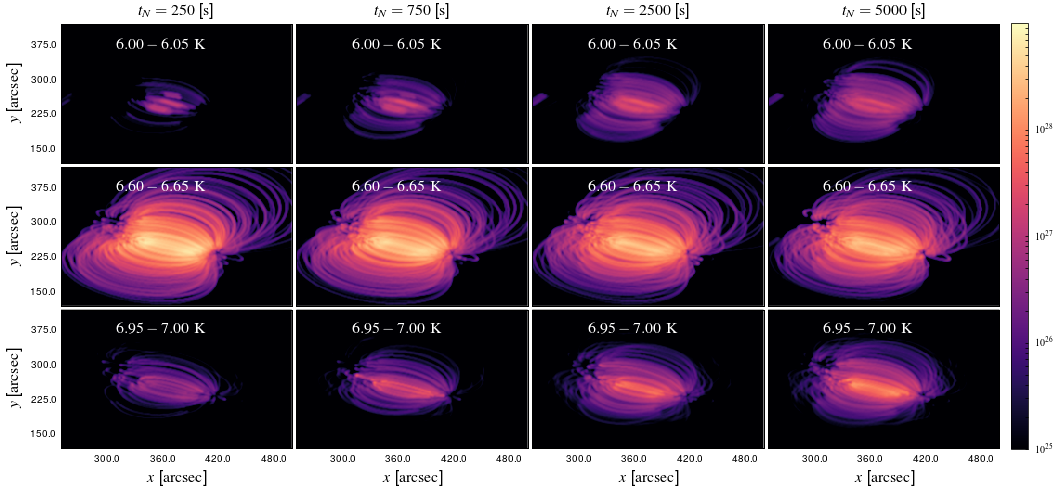

In [89]:
best_ratio = 1.65
fig = plt.figure(figsize=(16,16/best_ratio))
plt.subplots_adjust(right=0.94,top=0.94,hspace=0.01,wspace=0.02)
cax = fig.add_axes([0.95, 0.33, 0.015, 0.61])
for i,tn in enumerate(frequencies):
    for j,tbin_index in enumerate(lower_temp_bin_index):
        # apply a filter to the 
        tmp = true_cube_dict[tn][tbin_index].submap(u.Quantity([250,500],u.arcsec),
                                                   u.Quantity([120,420],u.arcsec))
        tmp.data = gaussian_filter(tmp.data,1)
        # set up axes properly and add plot
        ax = fig.add_subplot(4,4,i+4*j+1,projection=tmp)
        im = tmp.plot(axes=ax,
                      annotate=False,
                      norm=matplotlib.colors.SymLogNorm(1,vmin=1e25,vmax=1e29),
                      cmap=plt.get_cmap('magma')
                     )
        # set title and labels
        xtext,ytext = tmp.data_to_pixel(310*u.arcsec,370*u.arcsec)
        ax.text(xtext.value,ytext.value,
                r'${t0:.2f}-{t1:.2f}$ {uni:latex}'.format(t0=np.log10(tmp.meta['temp_a']),
                                                    t1=np.log10(tmp.meta['temp_b']),
                                                    uni=u.Unit('K')),
                color='w',fontsize=plt.rcParams['axes.labelsize'])
        if j==0:
            ax.set_title(r'$t_N={:d}$ [{:latex}]'.format(tn,u.s))
        if j<2:
            ax.coords[0].set_ticklabel_visible(False)
        else:
            ax.coords[0].set_ticklabel(size=plt.rcParams['xtick.labelsize'])
            ax.coords[0].set_axislabel(r'$x$ [$\mathrm{{{}}}$]'.format(u.Unit(tmp.meta['cunit1'])),
                                       size=plt.rcParams['axes.labelsize'])
        if i == 0:
            ax.coords[1].set_ticklabel(size=plt.rcParams['ytick.labelsize'])
            ax.coords[1].set_axislabel(r'$y$ [$\mathrm{{{}}}$]'.format(u.Unit(tmp.meta['cunit2'])),
                                      size=plt.rcParams['axes.labelsize'])
        else:
            ax.coords[1].set_ticklabel_visible(False)
        ax.coords[0].set_ticks_visible(False)
        ax.coords[1].set_ticks_visible(False)
        ax.coords[0].grid(alpha=0)
        ax.coords[1].grid(alpha=0)
    
cbar = fig.colorbar(im,cax=cax)
cbar.ax.tick_params(axis='y',direction='in')
fig.savefig('../figures/em_maps_true.pdf')

In [90]:
predicted_cube_dict = {
    250: EMCube.restore(os.path.join(tmp_data_root,'em_cubes_demreg_tn250_t7500-12500.h5')),
    750: EMCube.restore(os.path.join(tmp_data_root,'em_cubes_demreg_tn750_t7500-12500.h5')),
    2500: EMCube.restore(os.path.join(tmp_data_root,'em_cubes_demreg_tn2500_t7500-12500.h5')),
    5000: EMCube.restore(os.path.join(tmp_data_root,'em_cubes_demreg_tn5000_t7500-12500.h5')),
}
lower_temp_bin_index = [8,17,27]

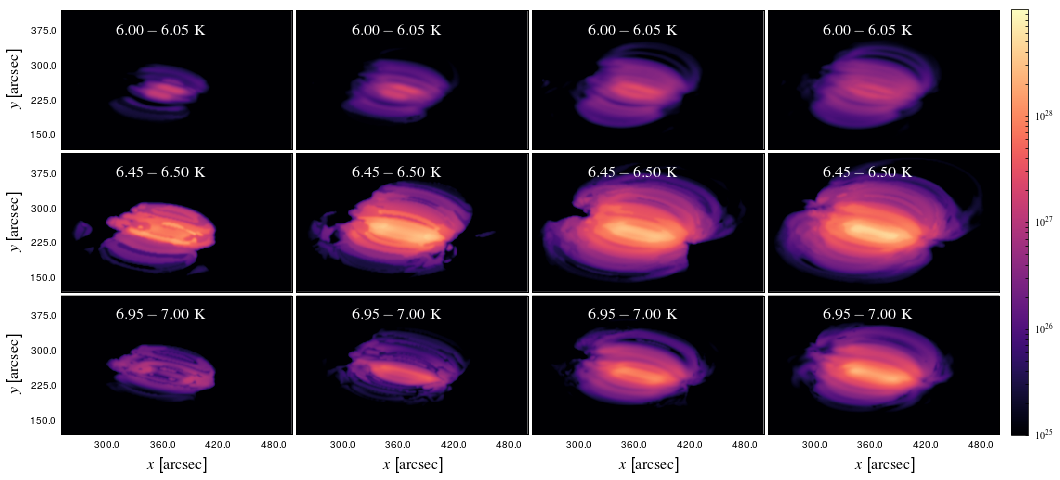

In [91]:
best_ratio = 1.65
fig = plt.figure(figsize=(16,16/best_ratio))
plt.subplots_adjust(right=0.94,top=0.94,hspace=0.01,wspace=0.02)
cax = fig.add_axes([0.95, 0.33, 0.015, 0.61])
for i,tn in enumerate(frequencies):
    for j,tbin_index in enumerate(lower_temp_bin_index):
        # apply a filter to the 
        tmp = predicted_cube_dict[tn][tbin_index].submap(u.Quantity([250,500],u.arcsec),
                                                   u.Quantity([120,420],u.arcsec))
        tmp.data = gaussian_filter(tmp.data,1)
        # set up axes properly and add plot
        ax = fig.add_subplot(4,4,i+4*j+1,projection=tmp)
        im = tmp.plot(axes=ax,
                      annotate=False,
                      norm=matplotlib.colors.SymLogNorm(1,vmin=1e25,vmax=1e29),
                      cmap=plt.get_cmap('magma')
                     )
        # set title and labels
        xtext,ytext = tmp.data_to_pixel(310*u.arcsec,370*u.arcsec)
        ax.text(xtext.value,ytext.value,
                r'${t0:.2f}-{t1:.2f}$ {uni:latex}'.format(t0=np.log10(tmp.meta['temp_a']),
                                                    t1=np.log10(tmp.meta['temp_b']),
                                                    uni=u.Unit('K')),
                color='w',fontsize=plt.rcParams['axes.labelsize'])
        #if j==0:
        #    ax.set_title(r'$t_N={:d}$ [{:latex}]'.format(tn,u.s))
        if j<2:
            ax.coords[0].set_ticklabel_visible(False)
        else:
            ax.coords[0].set_ticklabel(size=plt.rcParams['xtick.labelsize'])
            ax.coords[0].set_axislabel(r'$x$ [$\mathrm{{{}}}$]'.format(u.Unit(tmp.meta['cunit1'])),
                                       size=plt.rcParams['axes.labelsize'])
        if i == 0:
            ax.coords[1].set_ticklabel(size=plt.rcParams['ytick.labelsize'])
            ax.coords[1].set_axislabel(r'$y$ [$\mathrm{{{}}}$]'.format(u.Unit(tmp.meta['cunit2'])),
                                      size=plt.rcParams['axes.labelsize'])
        else:
            ax.coords[1].set_ticklabel_visible(False)
        ax.coords[0].set_ticks_visible(False)
        ax.coords[1].set_ticks_visible(False)
        ax.coords[0].grid(alpha=0)
        ax.coords[1].grid(alpha=0)
    
cbar = fig.colorbar(im,cax=cax)
cbar.ax.tick_params(axis='y',direction='in')
fig.savefig('../figures/em_maps_predicted.pdf')

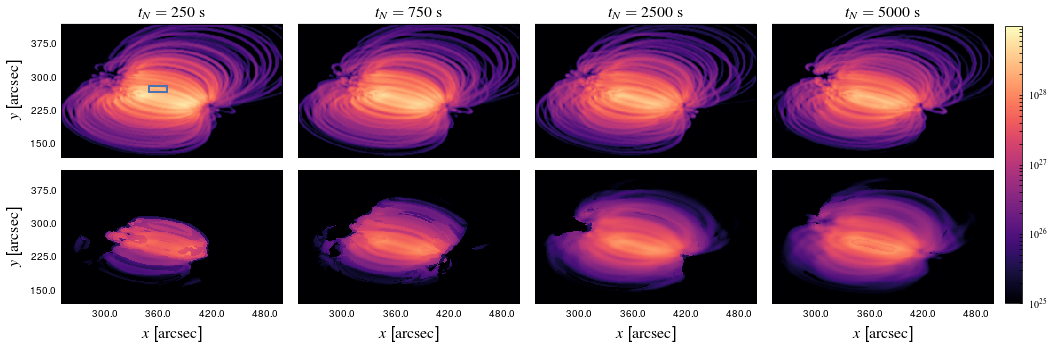

In [220]:
best_ratio = 3.4
fig = plt.figure(figsize=(16,16/best_ratio))
plt.subplots_adjust(right=0.945,top=0.95,hspace=0.1,wspace=0.015)
cax = fig.add_axes([0.95, 0.125, 0.015, 0.82])
norm = matplotlib.colors.SymLogNorm(1,vmin=1e25,vmax=1e29)
cmap = plt.get_cmap('magma')
for i,freq in enumerate(frequencies):
    # add true emission measure
    tmp_true = (true_cube_dict[freq][20]
                #.total_emission
                .submap(u.Quantity([250,500],u.arcsec),u.Quantity([120,420],u.arcsec))
               )
    tmp_true.data = gaussian_filter(tmp_true.data,1)
    ax = fig.add_subplot(2,4,i+1,projection=tmp_true)
    im = tmp_true.plot(axes=ax,
                       annotate=False,
                       norm=norm,
                       cmap=cmap
                      )
    ax.set_title(r'$t_N={:d}$ {:latex}'.format(freq,u.s))
    # ticks, labels, etc
    ax.coords[0].set_ticklabel_visible(False)
    if i%4 == 0:
        ax.coords[1].set_ticklabel(size=plt.rcParams['ytick.labelsize'])
        ax.coords[1].set_axislabel(r'$y$ [$\mathrm{{{}}}$]'.format(u.Unit(tmp.meta['cunit2'])),
                                  size=plt.rcParams['axes.labelsize'])
    else:
        ax.coords[1].set_ticklabel_visible(False)
    ax.coords[0].set_ticks_visible(False)
    ax.coords[1].set_ticks_visible(False)
    ax.coords[0].grid(alpha=0)
    ax.coords[1].grid(alpha=0)
    if i==0:
        tmp_true.draw_rectangle(u.Quantity((left_x,bottom_y)),
                                width,height,color=sns.color_palette()[0],lw=2)
    # add predicted emission measure
    tmp_predicted = (predicted_cube_dict[freq][20]
                     #.total_emission
                     .submap(u.Quantity([250,500],u.arcsec),u.Quantity([120,420],u.arcsec))
                    )
    ax = fig.add_subplot(2,4,i+5,projection=tmp_predicted)
    im = tmp_predicted.plot(axes=ax,
                            annotate=False,
                            norm=norm,
                            cmap=cmap
                           )
    # ticks, labels, etc
    ax.coords[0].set_ticklabel(size=plt.rcParams['xtick.labelsize'])
    ax.coords[0].set_axislabel(r'$x$ [$\mathrm{{{}}}$]'.format(u.Unit(tmp.meta['cunit1'])),
                               size=plt.rcParams['axes.labelsize'])
    if i%4 == 0:
        ax.coords[1].set_ticklabel(size=plt.rcParams['ytick.labelsize'])
        ax.coords[1].set_axislabel(r'$y$ [$\mathrm{{{}}}$]'.format(u.Unit(tmp.meta['cunit2'])),
                                   size=plt.rcParams['axes.labelsize'])
    else:
        ax.coords[1].set_ticklabel_visible(False)
    ax.coords[0].set_ticks_visible(False)
    ax.coords[1].set_ticks_visible(False)
    ax.coords[0].grid(alpha=0)
    ax.coords[1].grid(alpha=0)
    
cbar = fig.colorbar(im,cax=cax)
cbar.ax.tick_params(axis='y',direction='in')
fig.savefig('../figures/total_em_maps.pdf')

## 1D Emission Measure Distributions

### Data from Warren et al. (2012)

In [150]:
tmp = (urllib.request.urlopen('http://iopscience.iop.org/0004-637X/759/2/141/suppdata/apj446760t2_mrt.txt')
                     .readlines())
col_names = [str(t.strip()).split('  ')[-1] for t in tmp[8:15]]
col_names = [c[:-1] for c in col_names[0:2]] + ['Element','Ion','Wavelength'] + [c[:-1] for c in col_names[3:]]
table_io = io.StringIO(','.join(col_names) + '\n' 
                       + '\n'.join([','.join(filter(None,t.strip().decode('utf8').split(' '))) for t in tmp[19:]]))
df = pandas.read_csv(table_io)
df = df[df['Active region']==9]
df = df[df['Instrument (1)']=='EIS']
df = df.sort_values('Wavelength')

In [152]:
line_intensities = {'{}'.format(freq):{} for freq in frequencies}

In [153]:
eis = InstrumentHinodeEIS([7.5e3,1.25e4]*u.s)

In [157]:
for freq in frequencies:
    for channel in eis.channels:
        tmp = EISCube(os.path.join(tmp_data_root,'eis_intensity_{}_tn{}_t7500-12500.h5'.format(channel['name'],freq)))
        if type(freq) == int:
            tmp.data = (gaussian_filter(tmp.data.value,(channel['gaussian_width']['y'].value,
                                                        channel['gaussian_width']['x'].value,0.)))*tmp.data.unit
        for rw in resolved_wavelengths:
            i_center = np.where(np.isclose(tmp.wavelength.value,rw.value,atol=1.1e-2,rtol=0.))[0]
            if len(i_center) == 0:
                continue
            i_center = i_center[0]
            line_intensities['{}'.format(freq)][rw] = tmp[i_center-5:i_center+5].integrated_intensity

### Regularized Inversion Code

In [159]:
class DEM1DResults(object):
    
    def __init__(self,dem_results):
        self.temperature_bins = np.float64(dem_results['temperature_bins'])
        self.temperature_bin_centers = (self.temperature_bins[:-1] + self.temperature_bins[1:])/2.
        self.temperature_error_plus = self.temperature_bin_centers*(10.**(dem_results['elogt']) - 1.)
        self.temperature_error_minus = self.temperature_bin_centers*(1. - 10.**(-dem_results['elogt']))
        self.dem = dem_results['dem']
        self.em = dem_results['dem']*np.diff(self.temperature_bins)
        self.dem_errors = dem_results['edem']
        self.em_errors = np.diff(self.temperature_bins)*dem_results['edem']
        self.chi_squared = dem_results['chisq']
        self.regularized_data = dem_results['dn_reg']

In [160]:
static_input_vars = {
                     'log_temperature':np.log10(fake_loop.electron_temperature.value).tolist(),
                     'temperature_bins':true_cube_dict[250].temperature_bin_edges.value.tolist(),
                     'k_matrix':[contribution_functions[rw].value.tolist() for rw in resolved_wavelengths],
                     'names':['{} {}'.format(rw.value,rw.unit) for rw in resolved_wavelengths],
                     'error_ratio':0.25,
                     'gloci':1,'reg_tweak':1,'timed':1
                    }
save_vars = ['dem','edem','elogt','chisq','dn_reg','temperature_bins']
demreg_script = """
; load intensity from each channel/line
names = {{ names }}
intensity = {{ intensity }}
; load the contribution functions or response functions (called K in Hannah and Kontar 2012)
k_matrix = {{ k_matrix }}
; load temperature array over which K is computed
log_temperature = {{ log_temperature }}

; temperature bins
temperature_bins = {{ temperature_bins }}

; crude estimate of intensity errors
intensity_errors = intensity*{{ error_ratio }}

; inversion method parameters
reg_tweak={{ reg_tweak }}
timed={{ timed }}
gloci={{ gloci }}

; run the inversion method
dn2dem_pos_nb,intensity,intensity_errors,$
              k_matrix,log_temperature,temperature_bins,$
              dem,edem,elogt,chisq,dn_reg,$
              timed=timed,gloci=gloci,reg_tweak=reg_tweak
"""
demreg_runner = hissw.ScriptMaker(extra_paths=['/home/wtb2/Documents/codes/demreg/idl/'],
                                  ssw_path_list=['vobs','ontology'])

#### Simulated Data

In [161]:
demreg_simulate = {}
for freq in frequencies:
    input_vars = static_input_vars.copy()
    input_vars['intensity'] = [line_intensities['{}'.format(freq)][rw].submap(u.Quantity((left_x,right_x)),
                                                                              u.Quantity((bottom_y,top_y))).data.mean() 
                               for rw in resolved_wavelengths]
    demreg_simulate['{}'.format(freq)] = DEM1DResults(demreg_runner.run([(demreg_script,input_vars)],
                                                             save_vars=save_vars,
                                                             cleanup=True,verbose=True))

SSW  setup will include: <gen>

Type <sswidl> to start SSW IDL
--------------------------------------------------------
Running SSW, Last Updated: Wed Nov 2 22:22:51 GMT 2005
 
PROBLEMS? - e-mail TO: freeland@penumbra.nascom.nasa.gov
--------------------------------------------------------
IDL Version 8.5 (linux x86_64 m64). (c) 2015, Exelis Visual Information Solutions, Inc., a subsidiary of Harris Corporation.
Installation number: 401801-1.
Licensed for use by: Rice University

Executing SSW IDL_STARTUP for: GEN
Executing SSW IDL_STARTUP for: SITE
% Compiled module: SSW_PATH.
% Compiled module: SSW_INSTRUMENTS.
% Compiled module: WC_WHERE.
% Compiled module: PATHFIX.
% Compiled module: UNIQO.
% Compiled module: STRJUSTIFY.
% Compiled module: UNIQ.
% Compiled module: DEFAULT.
% Compiled module: PRSTR.
Including Paths:
 ---------------------------------
| $SSW/vobs/gen/idl               |
| $SSW/vobs/ontology/idl/jsoc     |
| $SSW/vobs/ontology/idl/gen_temp |
| $SSW/vobs/ontology/idl  

#### Observed Data

In [162]:
input_vars = static_input_vars.copy()
input_vars['intensity'] = [float(df['Observed intensity'][df['Wavelength'].apply(np.isclose, b=rw.value, atol=2e-2)])
                           for rw in resolved_wavelengths]
dem_output_warren = DEM1DResults(demreg_runner.run([(demreg_script,input_vars)],
                                                     save_vars=save_vars,
                                                     cleanup=True,verbose=True))

SSW  setup will include: <gen>

Type <sswidl> to start SSW IDL
--------------------------------------------------------
Running SSW, Last Updated: Wed Nov 2 22:22:51 GMT 2005
 
PROBLEMS? - e-mail TO: freeland@penumbra.nascom.nasa.gov
--------------------------------------------------------
IDL Version 8.5 (linux x86_64 m64). (c) 2015, Exelis Visual Information Solutions, Inc., a subsidiary of Harris Corporation.
Installation number: 401801-1.
Licensed for use by: Rice University

Executing SSW IDL_STARTUP for: GEN
Executing SSW IDL_STARTUP for: SITE
% Compiled module: SSW_PATH.
% Compiled module: SSW_INSTRUMENTS.
% Compiled module: WC_WHERE.
% Compiled module: PATHFIX.
% Compiled module: UNIQO.
% Compiled module: STRJUSTIFY.
% Compiled module: UNIQ.
% Compiled module: DEFAULT.
% Compiled module: PRSTR.
Including Paths:
 ---------------------------------
| $SSW/vobs/gen/idl               |
| $SSW/vobs/ontology/idl/jsoc     |
| $SSW/vobs/ontology/idl/gen_temp |
| $SSW/vobs/ontology/idl  

### Plot

In [163]:
def linear_fit(x,a,b):
        return a*x + b

/home/wtb2/anaconda3/envs/systematic-ar-study/lib/python3.5/site-packages/ipykernel/__main__.py:42: RuntimeWarning: divide by zero encountered in true_divide


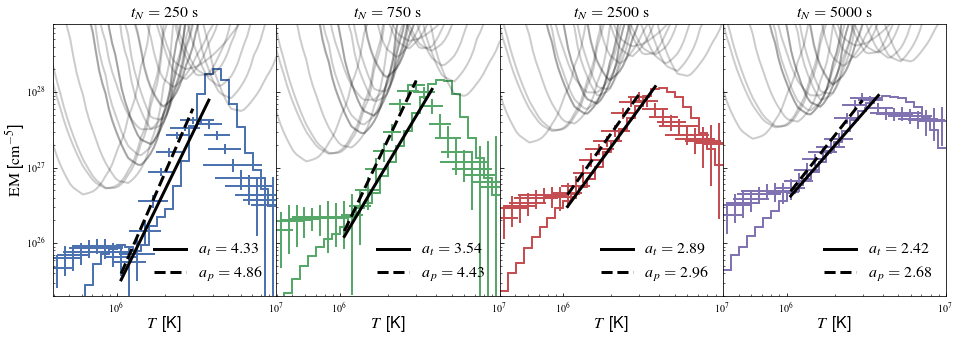

In [200]:
fig,axes = plt.subplots(1,4,figsize=(16,5))
plt.subplots_adjust(wspace=0,hspace=0)
for ax,(i,freq) in zip(axes.flatten(),enumerate([250,750,2500,5000])):
    #### Ground Truth ####
    # make 1d selection from boxed region
    temperature_bin_edges,em = true_cube_dict[freq].get_1d_distribution(u.Quantity((left_x,right_x)),
                                                                        u.Quantity((bottom_y,top_y)))
    # compute slope
    t_bin_centers = (temperature_bin_edges[1:] + temperature_bin_edges[:-1])/2.
    i_fit = np.where(np.logical_and(t_bin_centers>=1e6*u.K,
                                    t_bin_centers<=4e6*u.K))
    t_fit = t_bin_centers[i_fit].value
    em_fit = em[i_fit].value
    popt,pcov = curve_fit(linear_fit,np.log10(t_fit),np.log10(em_fit))
    # plot
    ax.step(temperature_bin_edges[:-1],em,where='post',
            color=sns.color_palette()[i],)
    ax.step(temperature_bin_edges[1:],em,where='pre',
            color=sns.color_palette()[i])
    ax.plot(t_fit,10.**linear_fit(np.log10(t_fit),*popt),c='k',lw=3,ls='-',alpha=1.0,
            label=r'$a_t={:.2f}$'.format(popt[0]))
    a_true = popt[0]
    #### Regularized DEM ####
    i_fit = np.where(np.logical_and(demreg_simulate['{}'.format(freq)].temperature_bin_centers>=1e6,
                                    demreg_simulate['{}'.format(freq)].temperature_bin_centers<=3e6))
    t_fit = demreg_simulate['{}'.format(freq)].temperature_bin_centers[i_fit]
    em_fit = demreg_simulate['{}'.format(freq)].em[i_fit]
    popt,pcov = curve_fit(linear_fit,np.log10(t_fit),np.log10(em_fit))
    ax.errorbar(demreg_simulate['{}'.format(freq)].temperature_bin_centers,
                demreg_simulate['{}'.format(freq)].em,
                yerr=demreg_simulate['{}'.format(freq)].em_errors,
                xerr=[demreg_simulate['{}'.format(freq)].temperature_error_minus,
                      demreg_simulate['{}'.format(freq)].temperature_error_plus],
                ls='',marker='',color=sns.color_palette()[i],
                )
    ax.plot(t_fit,10.**linear_fit(np.log10(t_fit),*popt),c='k',lw=3,ls='--',alpha=1.0,
            label=r'$a_p={:.2f}$'.format(popt[0]))
    a_pred = popt[0]
    # em loci curves
    for j,rw in enumerate(resolved_wavelengths):
        ax.plot(fake_loop.electron_temperature,
                demreg_simulate['{}'.format(freq)].regularized_data[j]/contribution_functions[rw],
                color='k',alpha=0.2)
    # show slopes label
    #ax.text(2e6,8e25,r'$a_{{t}}={:.2f}$'.format(a_true),
    #        fontsize=matplotlib.rcParams['axes.labelsize'])
    #ax.text(2e6,3e25,r'$a_{{p}}={:.2f}$'.format(a_pred),
    #        fontsize=matplotlib.rcParams['axes.labelsize'])
    # labels, ticks, etc
    ax.set_title(r'$t_N={}$ {:latex}'.format(freq,u.s),fontsize=matplotlib.rcParams['axes.labelsize'])
    ax.tick_params(axis='both',direction='in',which='both')
    ax.set_xscale('log')
    ax.set_yscale('log')
    ax.set_xlim([temperature_bin_edges[0].value,temperature_bin_edges[-1].value])
    ax.set_ylim([2e25,8e28])
    ax.set_xlabel(r'$T$ [{}]'.format(u.K))
    if i==0:
        ax.set_ylabel(r'$\mathrm{EM}$ [$\mathrm{cm}^{-5}$]')
    else:
        ax.set_yticklabels([])
    ax.legend(loc=4,frameon=False,fontsize=matplotlib.rcParams['axes.labelsize'],numpoints=1)

fig.savefig('../figures/em_1d_compare.pdf')

## Emission Measure Slopes

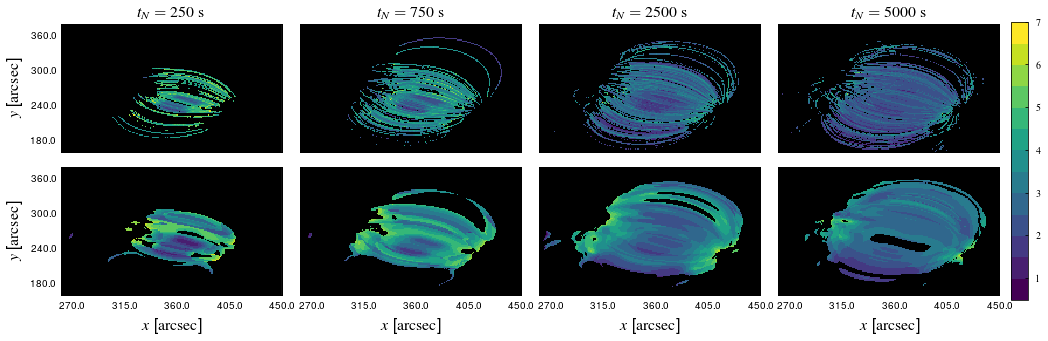

In [206]:
best_ratio = 3.4
fig = plt.figure(figsize=(16,16/best_ratio))
plt.subplots_adjust(right=0.94,top=0.95,hspace=0.05,wspace=0.08)
cax = fig.add_axes([0.95, 0.125, 0.015, 0.82])
custom_cmap = plt.get_cmap('viridis')
custom_cmap.set_under(color='k')
norm = matplotlib.colors.BoundaryNorm(np.arange(0.5,7.5,0.5),custom_cmap.N)
cut_x = u.Quantity([260,450],u.arcsec)
cut_y = u.Quantity([160,380],u.arcsec)
for i,freq in enumerate(frequencies):
    #### Ground Truth ####
    tmp = (EMCube.restore(os.path.join(tmp_data_root,'em_cubes_true_tn{}_t7500-12500.h5'.format(freq)))
           .make_slope_map(em_threshold=1e25*u.cm**(-5),
                           temperature_bounds=u.Quantity((1e6,4e6),u.K),
                           rsquared_tolerance=0.9
                          )
           .submap(cut_x,cut_y)
          )
    ax = fig.add_subplot(2,4,i+1,projection=tmp)
    im = (tmp.plot(cmap=custom_cmap,
                   axes=ax,
                   title=False,
                   annotate=False,
                   norm=norm))
    if i==0:
        ax.coords[1].set_axislabel(r'$y$ [$\mathrm{{{}}}$]'.format(u.Unit(tmp.meta['cunit2'])),
                                   size=plt.rcParams['axes.labelsize'])
        ax.coords[1].set_ticklabel(size=plt.rcParams['ytick.labelsize'])
    else:
        ax.coords[1].set_ticklabel_visible(False)
    ax.coords[0].set_ticklabel_visible(False)
    ax.coords[0].grid(alpha=0)
    ax.coords[1].grid(alpha=0)
    ax.coords[0].set_ticks_visible(False)
    ax.coords[1].set_ticks_visible(False)
    ax.set_title(r'$t_N={:d}$ {:latex}'.format(freq,u.s))
    
    #### Regularized Inversion ####
    tmp = (EMCube.restore(os.path.join(tmp_data_root,'em_cubes_demreg_tn{}_t7500-12500.h5'.format(freq)))
           .make_slope_map(em_threshold=1e25*u.cm**(-5),
                           temperature_bounds=u.Quantity((1e6,3e6),u.K),
                           rsquared_tolerance=0.9
                          )
           .submap(cut_x,cut_y)
          )
    ax = fig.add_subplot(2,4,i+5,projection=tmp)
    im = (tmp.plot(cmap=custom_cmap,
                   axes=ax,
                   title=False,
                   annotate=False,
                   norm=norm))
    ax.coords[0].set_axislabel(r'$x$ [$\mathrm{{{}}}$]'.format(u.Unit(tmp.meta['cunit1'])),
                               size=plt.rcParams['axes.labelsize'])
    ax.coords[0].set_ticklabel(size=plt.rcParams['xtick.labelsize'])
    if i==0:
        ax.coords[1].set_ticklabel(size=plt.rcParams['ytick.labelsize'])
        ax.coords[1].set_axislabel(r'$y$ [$\mathrm{{{}}}$]'.format(u.Unit(tmp.meta['cunit2'])),
                                   size=plt.rcParams['axes.labelsize'])
    else:
        ax.coords[1].set_ticklabel_visible(False)
    ax.coords[0].grid(alpha=0)
    ax.coords[1].grid(alpha=0)
    ax.coords[0].set_ticks_visible(False)
    ax.coords[1].set_ticks_visible(False)
        
cbar = fig.colorbar(im,cax=cax)
cbar.ax.tick_params(axis='y',direction='in')
cbar.set_ticks(np.linspace(1,7,7))
fig.savefig('../figures/em_slope_maps.pdf')

## Slope Distributions

Now, plot the flattened distributions for the true and predicted EM alongside the predicted distributions with the observational results overplotted.

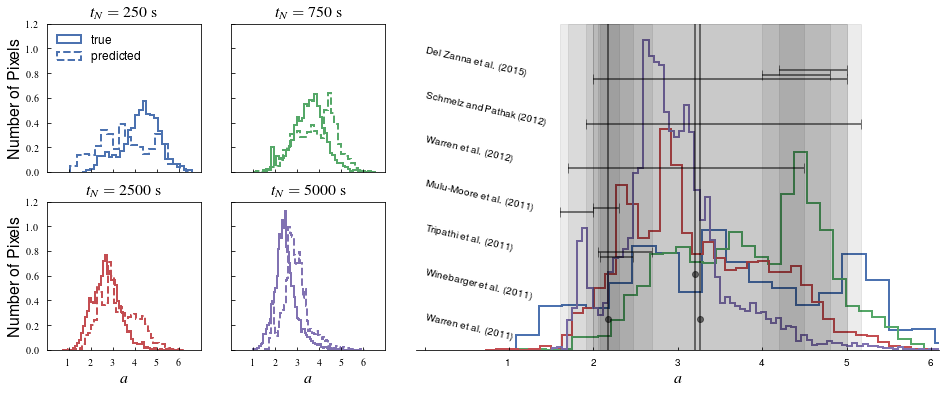

In [221]:
# setup figure and axes
fig = plt.figure(figsize=(16,6))
ax1 = plt.subplot2grid((2, 5), (0, 0))
ax2 = plt.subplot2grid((2, 5), (0, 1))
ax3 = plt.subplot2grid((2, 5), (1, 0))
ax4 = plt.subplot2grid((2, 5), (1, 1))
ax5 = plt.subplot2grid((2, 5), (0, 2),rowspan=3,colspan=3)
axes = [ax1,ax2,ax3,ax4]
# iterate over frequencies, plot distributions for
for i,freq in enumerate(frequencies):
    #### Ground Truth ####
    tmp = (EMCube.restore(os.path.join(tmp_data_root,'em_cubes_true_tn{}_t7500-12500.h5'.format(freq)))
           .make_slope_map(em_threshold=1e25*u.cm**(-5),
                           temperature_bounds=u.Quantity((1e6,4e6),u.K),
                           rsquared_tolerance=0.9
                          )
           .data.flatten()
          )
    tmp = tmp[tmp>0]
    axes[i].hist(tmp,bins='fd',histtype='step',log=False,label='true',
                 normed=True,lw=2,alpha=1.,color=sns.color_palette()[i])
    
    #### Regularized Inversion ####
    tmp = (EMCube.restore(os.path.join(tmp_data_root,'em_cubes_demreg_tn{}_t7500-12500.h5'.format(freq)))
           .make_slope_map(em_threshold=1e25*u.cm**(-5),
                           temperature_bounds=u.Quantity((1e6,3e6),u.K),
                           rsquared_tolerance=0.9
                          )
           .data.flatten()
          )
    tmp = tmp[tmp>0]
    axes[i].hist(tmp,bins='fd',histtype='step',log=False,label='predicted',
                 normed=True,lw=2,ls='--',alpha=1.,color=sns.color_palette()[i])
    
    # axes and ticks
    axes[i].set_xlim([0,7])
    axes[i].set_ylim([0,1.2])
    if i%2 != 0:
        axes[i].set_yticklabels([])
    else:
        axes[i].set_ylabel(r'Number of Pixels')
    axes[i].set_xticks(np.arange(1,7,1).tolist())
    if i < 2:
        axes[i].set_xticklabels([])
    else:
        axes[i].set_xlabel(r'$a$')
    axes[i].set_title(r'$t_N={:d}$ {:latex}'.format(freq,u.s))
    axes[i].tick_params(axis='both',direction='in')
axes[0].legend(loc=2,frameon=False)

### make schematic plot of slopes and observational results
## data
observed_slopes = []
observed_slopes.append(('Warren et al. (2011)',[2.17,3.26]))
observed_slopes.append(('Winebarger et al. (2011)',[3.2]))
observed_slopes.append(('Tripathi et al. (2011)',[[2.08,2.47],[2.05,2.7]]))
observed_slopes.append(('Mulu-Moore et al. (2011)',[[1.6,2],[2,2.3]]))
observed_slopes.append(('Warren et al. (2012)',[[1.7,4.5]]))
observed_slopes.append(('Schmelz and Pathak (2012)',[[1.91,5.17]]))
#observed_slopes.append(('Bradshaw et al. (2012)',[[1.7,2.6]]))
#observed_slopes.append(('Reep et al. (2013)',[[0.88,4.56]]))
#observed_slopes.append(('Cargill et al. (2014)',[[2,5]]))
observed_slopes.append(('Del Zanna et al. (2015)',[[2,5],[4,4.8],[4.2,5]]))
## plot
offset=0.1
# results from model
for i,freq in enumerate(frequencies):
    tmp = (EMCube.restore(os.path.join(tmp_data_root,'em_cubes_demreg_tn{}_t7500-12500.h5'.format(freq)))
           .make_slope_map(em_threshold=1e25*u.cm**(-5),
                           temperature_bounds=u.Quantity((1e6,3e6),u.K),
                           rsquared_tolerance=0.9
                          )
           .data.flatten()
          )
    tmp = tmp[tmp>0]
    ax5.hist(tmp,bins='fd',histtype='step',log=False,label='$t_N={}$ s'.format(freq),normed=True,
             lw=2,ls='-',alpha=1.,color=sns.color_palette()[i])
# results from literature
for i,slope in enumerate(observed_slopes):
    ax5.text(0,i/len(observed_slopes)+0.1,slope[0],rotation=-13,
             fontsize=plt.rcParams['xtick.labelsize'])
    for j,a in enumerate(slope[1]):
        if type(a) == list:
            _,caps,_ = ax5.errorbar(np.array(a).mean(),(j*offset + i + 0.1)/len(observed_slopes),
                                   color='k',ls='-',marker='',capsize=5,alpha=0.5,
                                   xerr=np.fabs(np.array(a).reshape((2,1)) - np.array(a).mean()))
            for cap in caps:
                cap.set_markeredgewidth(1)
            #ax.plot(a,j*offset+np.array([i,i]),color='k',ls='-',marker='')
            ax5.axvspan(a[0],a[1],color='k',alpha=0.075)
        else:
            ax5.plot(a,i/len(observed_slopes)+0.1,color='k',ls='',marker='o',alpha=0.5,)
            ax5.axvline(a,color='k',alpha=0.5)
# frame, axes, ticks
# set limits
ax5.set_xlim([-0.1,6.1])
ax5.set_ylim([0,1.05])
# set labels
ax5.set_xlabel(r'$a$')
new_x_lab = [int(lab) if 1<=int(lab)<=6 else '' for lab in ax5.get_xticks().tolist()]
ax5.set_xticklabels(new_x_lab)
ax5.tick_params(axis='x',direction='in')
ax5.set_yticklabels([])
ax5.set_yticks([])
sns.despine(ax=ax5,left=True,right=True,top=True)
fig.savefig('../figures/slope_distributions.pdf')